## Libraries

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy.interpolate import make_interp_spline, BSpline

## Get Data

In [11]:
with open('./data/processed/codes_to_city_dict.txt', 'rb') as handle:
    codes_to_city = pickle.loads(handle.read())
dat = pd.read_pickle('./data/processed/final/all-sched-enriched.pkl')
dat.head()

,operator,flight,aircraft,craft_capacity,frequency,weekly_flights,weekly_capacity,weekly_est_pass,from,from_time,...,to_time_slot,eff_from,eff_to,day_1,day_2,day_3,day_4,day_5,day_6,day_7
0,IND,6E 101,A 320,183,"[1, 2, 3, 4, 5, 6, 7]",7,1281,1125.0,MAA,6.25,...,15.0,2019-10-27 00:00:00,2020-03-28 00:00:00,True,True,True,True,True,True,True
1,IND,6E 103,A 320,183,"[1, 2, 3, 4, 5, 6, 7]",7,1281,1125.0,PNQ,22.33,...,1.0,2019-10-27 00:00:00,2020-03-28 00:00:00,True,True,True,True,True,True,True
2,IND,6E 104,A 320,183,"[1, 2, 3, 4, 5, 6, 7]",7,1281,1125.0,HYD,8.17,...,23.0,2019-10-27 00:00:00,2020-03-28 00:00:00,True,True,True,True,True,True,True
3,IND,6E 105,A 320,183,"[1, 2, 3, 4, 5, 7]",6,1098,964.0,PNQ,17.33,...,38.0,2019-10-27 00:00:00,2020-03-28 00:00:00,True,True,True,True,True,False,True
4,IND,6E 105,A 320,183,"[1, 2, 3, 4, 5, 7]",6,1098,964.0,DEL,14.75,...,34.0,2019-10-27 00:00:00,2020-03-27 00:00:00,True,True,True,True,True,False,True


#### Traffic Metrics for Cities

<ul>
    <li>Create a new dataframe by wrangling dat to identify for each city, across all carriers:
        <ol>
            <li>weekly total number of movements (arrivals plus departures).
            <li>weekly capacity.
            <li>weekly estimated passengers
        </ol>
</ul>

Identify the top cities that account for 80% of each weekly totals.

In [12]:
weeklies_ = ['weekly_flights', 'weekly_capacity', 'weekly_est_pass']

from_flights = dat.groupby(['from'])[weeklies_].sum()
to_flights = dat.groupby(['to'])[weeklies_].sum()

sdat = pd.concat([from_flights, to_flights], axis = 1, ignore_index = True)
sdat = sdat.fillna(0, axis = 1, downcast = 'infer') # if there are no flights either from or to a city, 
                                                    # replace NA by 0
sdat = sdat.rename(columns = {0:'from_weekly_flights', 
                                            3:'to_weekly_flights',
                                            1:'from_weekly_capacity',
                                            4:'to_weekly_capacity',
                                            2:'from_weekly_est_pass',
                                            5:'to_weekly_est_pass'}, errors = 'raise')

sdat['total_weekly_mvmnts'] = sdat.apply(lambda row: row.from_weekly_flights + row.to_weekly_flights,axis = 1)
sdat['total_weekly_capacity'] = sdat.apply(lambda row: row.from_weekly_capacity + row.to_weekly_capacity, 
                                           axis = 1)
sdat['total_weekly_est_pass'] = sdat.apply(lambda row: row.from_weekly_est_pass + row.to_weekly_est_pass, 
                                           axis = 1)

sdat.head()

,from_weekly_flights,from_weekly_capacity,from_weekly_est_pass,to_weekly_flights,to_weekly_capacity,to_weekly_est_pass,total_weekly_mvmnts,total_weekly_capacity,total_weekly_est_pass
AGR,4,280,218,4,280,218,8,560,436
AGX,7,490,383,7,490,383,14,980,766
AIP,7,546,500,7,546,500,14,1092,1000
AJL,11,1342,1046,24,3782,3223,35,5124,4269
AMD,764,124123,109080,750,120574,105987,1514,244697,215067


In [13]:
def top_cities_feature(df, feature, threshold = 0.8):
    '''
    
    Returns the list top cities (by code) that account for threshold percentage of weekly total of the 
    desired feature.
    
    '''
    
    df = df.sort_values(by = [feature], ascending = False)   
    total = df[feature].sum()
    top_cities = round(df[feature].cumsum()/total, 2)
        
    return top_cities[top_cities <= threshold].index.tolist()

In [24]:
top_cities = top_cities_feature(sdat, 'total_weekly_est_pass')

['DEL', 'BOM', 'BLR', 'HYD', 'CCU', 'MAA', 'AMD', 'PNQ', 'GOI', 'GAU', 'LKO', 'PAT', 'JAI', 'COK', 'BBI', 'VNS', 'IDR']


In [15]:
def fill_missing(series, slots, na_val):
    
    '''
    
    In a series with an expected numerically ascending index, identifies if a particular index value
    is missing and inserts a new entry with such missing index value with the desired na_val.
    
    Finally, reorder the new series to ensure that the inserted index values are in their appropriate 
    position
    
    '''
    
    if series.shape[0] != slots:
        missing_idx = list(set(np.arange(1, slots+1, 1)).difference(series.index))
        for i in missing_idx:
            series[float(i)] = na_val
    
    series = series.sort_index()
    return series

In [91]:
def todd_by_metric(df, metric, city = 'ALL'):
    
    ''' 
    
    For a city and for a traffic metric (movements, capacity, estimated passengers), returns the weekly
    time-of-day distribution grouped by:
        flights into the city
        flights out of the city
        
    When combined across all cities, for any time of day slot, the total value of the metric for flights in 
    would be the same as the total value of the metric for flights out (for e.g. the total number of 
    arrivals must be equal to the total number of departures). 
    
    However, this may not be true when considering a particular city, i.e. the total number of arrivals in a 
    city may not be the same as the total number of departures. 
    
    '''
    
    _in =[]
    _out = []
    
    if city == 'ALL':
        _in = (df.groupby(['to_time_slot'])[metric].sum())
        _in = fill_missing(_out, 48, 0)
        _out = (df.groupby(['from_time_slot'])[metric].sum())
        _out = fill_missing(_out, 48, 0)
    else:
        idx = [i for i in dat.index if dat['from'][i] == city or dat['to'][i] == city]
        sdat = dat.iloc[idx, :]

        idx_in = [i for i in sdat.index if sdat['to'][i] == city]     # flights into the city
        idx_out = [i for i in sdat.index if sdat['from'][i] == city]  # flights out of the city

        _in = (sdat.loc[idx_in, :].groupby(['to_time_slot'])[metric].sum())
        _in = fill_missing(_in, 48, 0)
        _out = (sdat.loc[idx_out, :].groupby(['from_time_slot'])[metric].sum())
        _out = fill_missing(_out, 48, 0)
    
    return _in, _out
    

In [86]:
pass_in, pass_out = todd_by_metric(dat, 'weekly_est_pass')

In [87]:
def spread_traffic(traffic, sprd_ovr, pass_dir_in = False):
    
    '''
    
    'Spreads' passenger traffic over adjacent timeslots. Expects traffic to be a pandas Series object.
    
    Incoming passengers at an airport start departing from the airport, and do so evenly in sprd_ovr number
    of slots post the to_time_slot i.e. the timeslot in which their flight arrives.
    Outgoing passengers from an airport start arriving at the airpot and do so evenly in sprd_over number
    of slots prior to the from_time_slot i.e. the timeslot in which their flight leaves.
    
    pass_dir_in is a boolean flag to decide if function needs to spread incoming traffic (True) of outgoing
    traffic
    
    '''
    
    traffic_adj = pd.Series(data = 0, index = traffic.index, dtype = 'float')
    
    if pass_dir_in == True:
        for i in range(1, 49):              # spreading the passengers at the airport for incoming flights
            dist_ = traffic[i]/sprd_ovr
            for j in range(i+1, i+3):
                if j > 48: j = j - 48
                traffic_adj[j] += dist_
    else:
        for i in range(1, 49):              # spreading the passengers at the airport for outgoing flights
            dist_ = traffic[i]/sprd_ovr
            for j in range(i-sprd_ovr, i):
                if j < 1: j = 48 + j
                traffic_adj[j] += dist_
                    
    return traffic_adj

In [88]:
pass_in_adj = spread_traffic(pass_in, 2, True)
pass_out_adj = spread_traffic(pass_out, 4)
pass_total_adj = [sum(x) for x in zip(pass_in_adj, pass_out_adj)]

In [89]:
def plot_distbn(psg_traf, city = 'ALL', label = 'Incoming+Outgoing', spline_pts = 100, smoothing_param = 2):
    
    '''
    
    Plots a smooth curve (spline) for Time-of-Day distribution of passenger traffic.
    
    psg_traf - List of hourly passenger traffic.
    city - either 'ALL' for all cities combined or the relevant IATA code for a specific city
    spline_pts, smoothing_param - parameters of the spline drawn
    
    '''
    
    x_orig = np.arange(1, 49 ,1)
    x_augm = np.linspace(1, 48, spline_pts)
    spline = make_interp_spline(x_orig, psg_traf, k = smoothing_param)
    y_axis = np.maximum(np.zeros(spline_pts), spline(x_augm))      # prevent y from taking a negative value

    plt.xlabel('Hour of the Day')
    plt.ylabel('Passenger Traffic')

    plt.xticks(np.arange(0, 49, 2), labels = np.arange(0, 25, 1))  # to get 24 hours on the x-axis
    plt.axvline(x = 12, color = 'black', linestyle = '--')         # 6 a.m.
    plt.axvline(x = 24, color = 'black', linestyle = '--')         # 12 noon
    plt.axvline(x = 36, color = 'black', linestyle = '--')         # 6 p.m.
    
    if city == 'ALL': plt.title('Daily Average Hourly Passenger Traffic - All Cities')
    else: plt.title('Daily Average Hourly Passenger Traffic in %s' % codes_to_city[city])
        
    plt.plot(x_augm, y_axis, label = label)
    plt.legend()
    
    return        

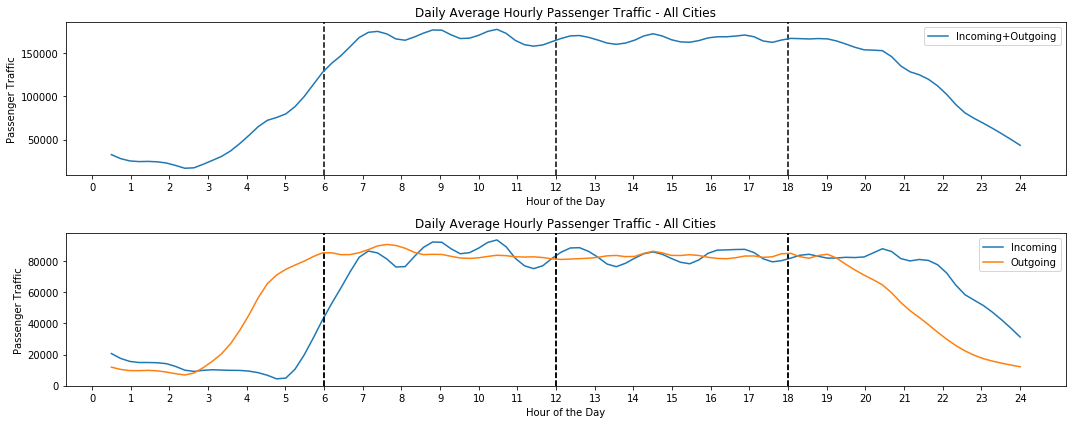

In [90]:
plt.figure(figsize = (15, 6))

plt.subplot(2, 1, 1)
plot_distbn(pass_total_adj)

plt.subplot(2, 1, 2)
plot_distbn(pass_in_adj, label = 'Incoming')
plot_distbn(pass_out_adj, label = 'Outgoing')

plt.tight_layout()
plt.show()

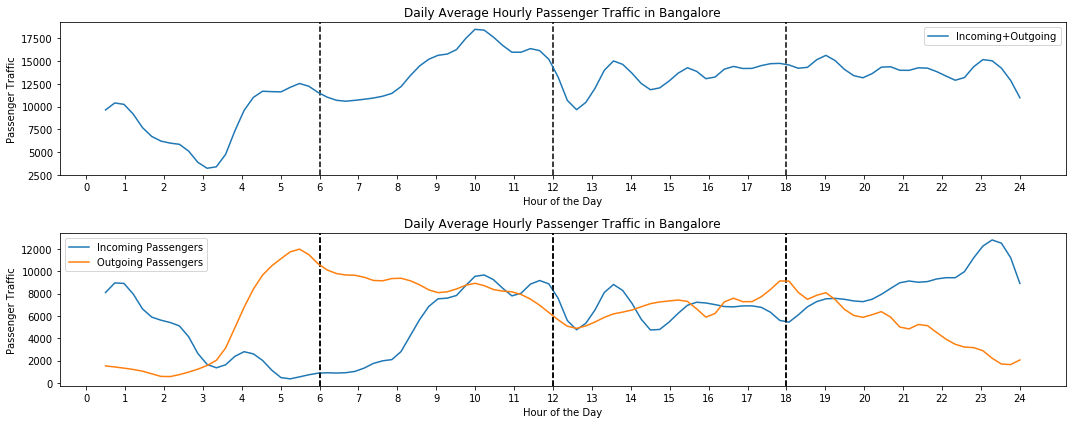

In [73]:
city = 'BLR'

pass_in, pass_out = todd_by_metric(dat, 'weekly_est_pass', city = city)

pass_in_adj = spread_traffic(pass_in, 2, True)
pass_out_adj = spread_traffic(pass_out, 4)
pass_total_adj = [sum(x) for x in zip(pass_in_adj, pass_out_adj)]

plt.figure(figsize = (15, 6))

plt.subplot(2, 1, 1)
plot_distbn(pass_total_adj, city = city)

plt.subplot(2, 1, 2)
plot_distbn(pass_in_adj, city = city, label = 'Incoming Passengers')
plot_distbn(pass_out_adj, city = city, label = 'Outgoing Passengers')

plt.tight_layout()
plt.show()

In [140]:
def traf_at_loc(psg_traf, time_to_airport):
    
    '''
    
    time_to_airport - Time taken in hours from the location to reach the airport. 
                      If negative, implies time taken from airport to reach the location.
    '''
    
    psg_traf_loc = pd.Series(data = 0, index = psg_traf.index, dtype = 'float')
    timeslots = np.ceil(time_to_airport*2)           # translates time_to_airport into equivalent number of 
                                                     # 1/2 hour slots.
    
    for i in range(1, 49):
        shifted_i = i + timeslots
        if shifted_i > 48: 
            shifted_i = shifted_i - 48
        elif shifted_i < 1:
            shifted_i = 48 + shifted_i
        
        psg_traf_loc[i] = psg_traf[shifted_i]
        
        
    return psg_traf_loc

In [138]:
def plot_distbn_loc(psg_traf, loc, label = 'Both Ways Combined', spline_pts = 300, smoothing_param = 2):
    
    '''
    
    Plots a smooth curve (spline) for Time-of-Day distribution of passenger traffic.
    
    psg_traf - List of hourly passenger traffic.
    city - either 'ALL' for all cities combined or the relevant IATA code for a specific city
    spline_pts, smoothing_param - parameters of the spline drawn
    
    '''
    
    x_orig = np.arange(1, 49 ,1)
    x_augm = np.linspace(1, 48, spline_pts)
    spline = make_interp_spline(x_orig, psg_traf, k = smoothing_param)
    y_axis = np.maximum(np.zeros(spline_pts), spline(x_augm))      # prevent y from taking a negative value

    plt.xlabel('Hour of the Day')
    plt.ylabel('Passenger Traffic')

    plt.xticks(np.arange(0, 49, 2), labels = np.arange(0, 25, 1))  # to get 24 hours on the x-axis
    plt.axvline(x = 12, color = 'black', linestyle = '--')         # 6 a.m.
    plt.axvline(x = 24, color = 'black', linestyle = '--')         # 12 noon
    plt.axvline(x = 36, color = 'black', linestyle = '--')         # 6 p.m.
    
    plt.title('Daily Average Hourly Passenger Traffic at %s' % loc)
        
    plt.plot(x_augm, y_axis, label = label)
    plt.legend()
    
    return        

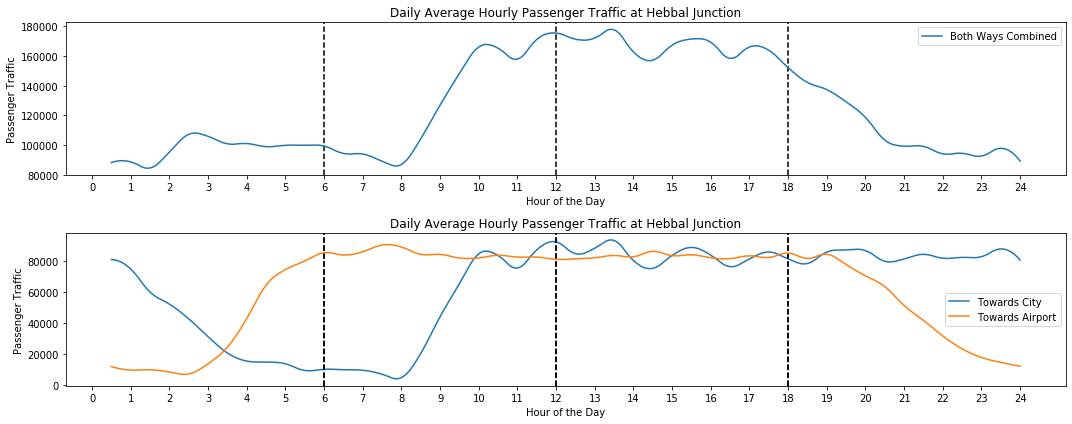

In [145]:
pass_in_loc = traf_at_loc(pass_in_adj, -3)
pass_out_loc = traf_at_loc(pass_out_adj, 0)
pass_total_loc = [sum(x) for x in zip(pass_in_hebbal, pass_out_hebbal)]

plt.figure(figsize = (15, 6))

plt.subplot(2, 1, 1)
plot_distbn_loc(pass_total_loc, loc = 'Hebbal Junction')

plt.subplot(2, 1, 2)
plot_distbn_loc(pass_in_loc, loc = 'Hebbal Junction', label = 'Towards City')
plot_distbn_loc(pass_out_loc, loc = 'Hebbal Junction', label = 'Towards Airport')

plt.tight_layout()
plt.show()